<a href="https://colab.research.google.com/github/windopper/NLPDeepLearningPractice/blob/main/TextClassificationUsingRNN/korea_steam_review_analysis_using_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BiLSTM으로 한국어 스팀 리뷰 감성 분류

In [1]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 22.81 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 3.7 MB/s 
     |████████████████████████████████| 448 kB 33.0 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-02-03 05:01:27--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::6b17:d1f5, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loc

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7fd929434690>)

In [4]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data))

전체 리뷰 개수 : 100000


In [5]:
total_data[:5]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


중복 확인 및 제거

In [6]:
total_data['reviews'].nunique(), total_data['label'].nunique()

(99892, 2)

In [7]:
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플의 수 : ', len(total_data))

총 샘플의 수 :  99892


null 값 유무 확인

In [8]:
total_data.isnull().values.any()

False

훈련 데이터와 테스트 데이터를 3:1 비율로 분리

In [9]:
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state = 42)
print("훈련용 리뷰의 개수 : ", len(train_data))
print('테스트용 리뷰의 개수 : ', len(test_data))

훈련용 리뷰의 개수 :  74919
테스트용 리뷰의 개수 :  24973


훈련 데이터의 레이블의 분포 확인

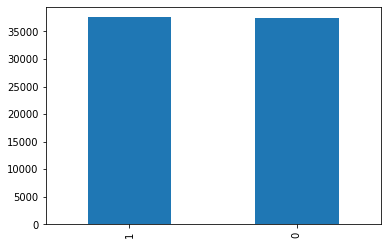

In [10]:
train_data['label'].value_counts().plot(kind='bar')

In [11]:
train_data.groupby('label').size().reset_index(name='count')

,label,count
0,0,37376
1,1,37543


데이터 정제

한글을 제외하고 모두 제거. 또한 빈 샘플이 생겼는지 확인

In [13]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
train_data['reviews'].replace("",np.nan, inplace=True)
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [15]:
test_data.drop_duplicates(subset=['reviews'], inplace=True)
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
test_data['reviews'].replace("", np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print('전처리 후 샘플 개수 : ', len(test_data))

전처리 후 샘플 개수 :  24921


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


불용어 정의

In [16]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

한국어 형태소 분석기 mecab을 사용하여 토큰화

In [18]:
mecab = Mecab()

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x : [item for item in x if item not in stopwords])

각 레이블에 따라서 분류한 단어들을 별도로 저장

In [19]:
negative_words = np.hstack(train_data[train_data.label==0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label==1]['tokenized'].values)

negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 8129), ('없', 7141), ('는데', 5786), ('있', 5692), ('같', 4247), ('로', 4083), ('할', 3920), ('거', 3902), ('나', 3805), ('해', 3653), ('너무', 3522), ('으로', 3351), ('기', 3348), ('했', 3265), ('어', 3143), ('보', 2987), ('습니다', 2962), ('것', 2935), ('지만', 2911), ('좋', 2899)]


In [21]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('있', 9987), ('좋', 6542), ('습니다', 5179), ('재밌', 4997), ('할', 4838), ('지만', 4809), ('해', 4354), ('없', 4145), ('보', 3907), ('으로', 3900), ('로', 3879), ('수', 3835), ('는데', 3825), ('기', 3592), ('안', 3368), ('것', 3362), ('같', 3356), ('네요', 3189), ('어', 3112), ('나', 3055)]


긍정 리뷰의 평균 길이 : 14.948459100231734
부정 리뷰의 평균 길이 : 14.948459100231734


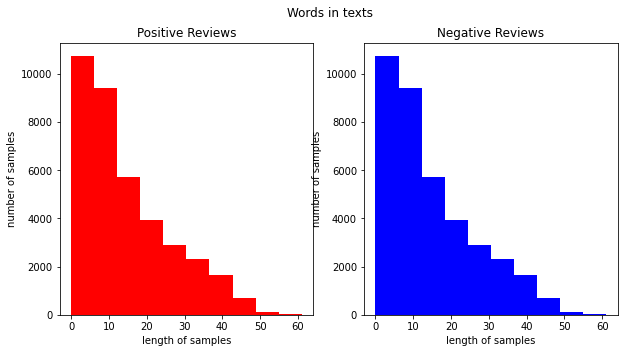

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

test_len = train_data[train_data['label']==0]['tokenized'].map(lambda x : len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :',np.mean(text_len))
plt.show()


In [46]:
x_train = train_data['tokenized'].values
y_train = train_data['label'].values
x_test = test_data['tokenized'].values
y_test = test_data['label'].values

정수 인코딩

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [48]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 총 단어의 수 
rare_cnt = 0 # threshold 보다 작은 단어의 개수
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  if(value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합의 크기 : ', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수 %s'%(threshold -1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율 : ', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : ', (rare_freq / total_freq) * 100)

단어 집합의 크기 :  32817
등장 빈도가 1번 이하인 희귀 단어의 수 13878
단어 집합에서 희귀 단어의 비율 :  42.28905750068562
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :  1.2254607619437832


In [49]:
# 전체 단어 개수 중 빈도수 2이상인 단어들은 제거
# 0번 padding token과 OOV token을 고려하여 +2

vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 : ', vocab_size)

단어 집합의 크기 :  18941


In [50]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [51]:
print(x_test[:3])

[[728, 34, 16, 431, 52, 106, 132, 99, 6461, 453], [4527, 687, 835, 712, 792, 108, 4, 1779, 95, 370, 3519, 81, 558, 1904, 4189, 262, 169, 61, 25, 363, 35, 87, 974, 19, 6294, 6422], [1792, 806, 685, 49, 23, 349]]


In [52]:
print(x_train[:3])

[[495, 7, 35, 87, 149, 2429, 599, 26, 8, 70, 47, 235, 111, 38, 44, 52], [161, 300, 18, 20, 63, 3582, 985, 6, 56], [7, 17, 1476, 4]]


패딩

리뷰의 최대 길이 :  64
리뷰의 평균 길이 :  15.115951894712957


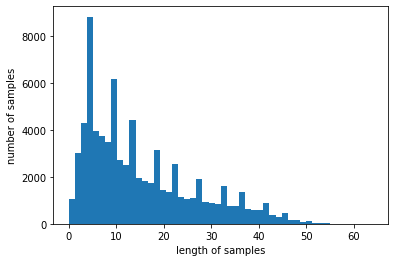

In [53]:
print('리뷰의 최대 길이 : ', max(len(x) for x in x_train))
print('리뷰의 평균 길이 : ', sum(map(len, x_train))/len(x_train))
plt.hist([len(review) for review in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

60으로 패딩할 경우 몇개의 샘플을 온전히 보전할 수 있는지 확인

In [54]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
      count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'% (max_len, (count / len(nested_list)) * 100))

In [55]:
max_len = 60
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율 : 99.99599567532935


60으로 패딩

In [56]:
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

모델 설계

LSTM이 Bidirectional() 안에 기재되었다는 점에 주목해야함

In [57]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(x_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
233/235 [============================>.] - ETA: 0s - loss: 0.5226 - acc: 0.7414
Epoch 00001: val_acc improved from -inf to 0.77750, saving model to best_model.h5
235/235 [==============================] - 12s 20ms/step - loss: 0.5225 - acc: 0.7417 - val_loss: 0.4750 - val_acc: 0.7775
Epoch 2/15
232/235 [============================>.] - ETA: 0s - loss: 0.4327 - acc: 0.8032
Epoch 00002: val_acc did not improve from 0.77750
235/235 [==============================] - 4s 16ms/step - loss: 0.4329 - acc: 0.8032 - val_loss: 0.4928 - val_acc: 0.7724
Epoch 3/15
233/235 [============================>.] - ETA: 0s - loss: 0.4038 - acc: 0.8198
Epoch 00003: val_acc improved from 0.77750 to 0.79104, saving model to best_model.h5
235/235 [==============================] - 4s 16ms/step - loss: 0.4038 - acc: 0.8199 - val_loss: 0.4587 - val_acc: 0.7910
Epoch 4/15
232/235 [============================>.] - ETA: 0s - loss: 0.3797 - acc: 0.8331
Epoch 00004: val_acc did not improve from 0.79104
23

In [62]:
loaded_model = load_model('best_model.h5')
print('테스트 정확도 : %.4f' % (loaded_model.evaluate(x_test, y_test)[1]))

779/779 [==============================] - 7s 8ms/step - loss: 0.4590 - acc: 0.7899
테스트 정확도 : 0.7899


리뷰 예측하기

In [66]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if word not in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen=max_len)
  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다".format(score * 100))
  else:
    print('{:.2f}% 확률로 부정 리뷰입니다'.format((1-score) * 100))

In [80]:
sentiment_predict('와 진짜 노잼이다')

92.17% 확률로 부정 리뷰입니다


In [83]:
sentiment_predict('이거 쫌 괜찮은 듯')

81.20% 확률로 긍정 리뷰입니다
